# Cleaning inputs for WCM

In [1]:
# Base
import os
import re
import time
import math
import numpy as np
import pandas as pd
import datetime as dtt

# Analysis
import pyswarms as ps
from scipy import special as sp
from scipy.optimize import curve_fit
from numpy.polynomial import Polynomial
from scipy.signal import savgol_filter as sfilter

# # Geospatial
# import fiona
# import xarray as xr
# import hydroeval as he
# # import geopandas as gpd
# # from maps_original import *

# Graphics
import seaborn as sns
import matplotlib as mplt
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# LAI

In [2]:
df_lai = pd.read_csv('..\\Data\\LAI\\2017\\LAI_Budrio.csv', delimiter = ",", header=None)
df_lai['Date'] = pd.date_range(start="2017-1-10",end="2017-12-31")

<AxesSubplot:>

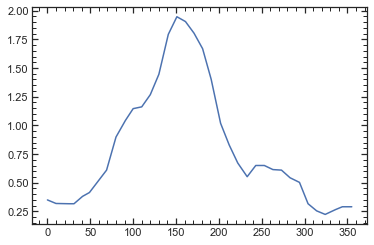

In [3]:
df_lai[1].plot()

In [4]:
df_lai = df_lai.drop(0, axis=1).rename(columns={1:'LAI[m2/m2]'})
df_lai

,LAI[m2/m2],Date
0,0.35038,2017-01-10
1,0.34728,2017-01-11
2,0.34418,2017-01-12
3,0.34108,2017-01-13
4,0.33797,2017-01-14
...,...,...
351,0.29069,2017-12-27
352,0.29069,2017-12-28
353,0.29069,2017-12-29
354,0.29069,2017-12-30


# Satellite and in-situ data: $\sigma^0$, angle, SM

In [5]:
df_sat = pd.read_csv(f'..\\Data\\Golden_GEE.csv', delimiter = "\t", index_col=0).rename(columns={'Date':'DateTime_sat'})
df_sat['Date'] = pd.to_datetime(pd.to_datetime(df_sat['DateTime_sat'].astype('str')).apply(lambda x: x.date()))
df_sat

,Angle[°],DateTime_sat,Geometry,Orb,Pass,VH[lin],VH_var[lin],VV[lin],VV_var[lin],VV[dB],VH[dB],VV_var[dB],VH_var[dB],SWC[m3/m3],Pioggia[mm],Irrigazione[mm],Temperatura[°C],VV_norm[dB],VH_norm[dB],Date
0,31.282551,2017-04-04 07:00:00,Budrio_half-right,168,DESCENDING,0.009136,0.000018,0.070329,0.000630,-11.528672,-20.392462,0.038881,0.008441,0.170173,0.0,0.0,8.7339,-12.343922,-20.828488,2017-04-04
1,41.103306,2017-04-05 07:00:00,Budrio_half-right,95,DESCENDING,0.006342,0.000010,0.090708,0.001534,-10.423533,-21.977589,0.073466,0.006573,0.147105,0.0,0.0,11.8548,-10.423533,-21.977589,2017-04-05
2,37.537476,2017-04-06 19:00:00,Budrio_half-right,117,ASCENDING,0.005942,0.000007,0.062548,0.000390,-12.037891,-22.260785,0.027052,0.004964,0.150527,0.0,0.0,15.6591,-11.275126,-21.874069,2017-04-06
3,31.368000,2017-04-10 07:00:00,Budrio_half-right,168,DESCENDING,0.006690,0.000009,0.066282,0.000831,-11.786029,-21.745415,0.054418,0.005718,0.159550,0.0,0.0,8.5507,-12.548264,-22.056497,2017-04-10
4,41.305325,2017-04-11 07:00:00,Budrio_half-right,95,DESCENDING,0.005057,0.000007,0.056139,0.000400,-12.507326,-22.961495,0.030916,0.005962,0.160673,0.0,0.0,10.5575,-12.507326,-22.961495,2017-04-11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102,41.293633,2017-10-26 07:00:00,Budrio_half-right,95,DESCENDING,0.011202,0.000027,0.093611,0.000985,-10.286710,-19.507143,0.045695,0.010312,0.155637,0.0,0.0,5.1388,-10.286710,-19.507143,2017-10-26
103,37.531326,2017-10-27 19:00:00,Budrio_half-right,117,ASCENDING,0.012791,0.000031,0.069743,0.000667,-11.565022,-18.931034,0.041511,0.010434,0.155525,0.0,0.0,14.4822,-10.849906,-18.851762,2017-10-27
104,31.386597,2017-10-31 06:00:00,Budrio_half-right,168,DESCENDING,0.010243,0.000017,0.159341,0.004745,-7.976737,-19.895653,0.129336,0.007121,0.167105,0.0,0.0,4.9978,-9.523675,-20.377558,2017-10-31
105,41.307350,2017-11-01 06:00:00,Budrio_half-right,95,DESCENDING,0.011606,0.000018,0.090067,0.000921,-10.454340,-19.353215,0.044419,0.006885,0.124052,NaN,0.0,NaN,-10.454340,-19.353215,2017-11-01


# Merge inputs on dates

In [6]:
df_tot = pd.merge(left=df_lai, right=df_sat, how='right', on='Date'); df_tot

,LAI[m2/m2],Date,Angle[°],DateTime_sat,Geometry,Orb,Pass,VH[lin],VH_var[lin],VV[lin],...,VV[dB],VH[dB],VV_var[dB],VH_var[dB],SWC[m3/m3],Pioggia[mm],Irrigazione[mm],Temperatura[°C],VV_norm[dB],VH_norm[dB]
0,0.95176,2017-04-04,31.282551,2017-04-04 07:00:00,Budrio_half-right,168,DESCENDING,0.009136,0.000018,0.070329,...,-11.528672,-20.392462,0.038881,0.008441,0.170173,0.0,0.0,8.7339,-12.343922,-20.828488
1,0.96509,2017-04-05,41.103306,2017-04-05 07:00:00,Budrio_half-right,95,DESCENDING,0.006342,0.000010,0.090708,...,-10.423533,-21.977589,0.073466,0.006573,0.147105,0.0,0.0,11.8548,-10.423533,-21.977589
2,0.97843,2017-04-06,37.537476,2017-04-06 19:00:00,Budrio_half-right,117,ASCENDING,0.005942,0.000007,0.062548,...,-12.037891,-22.260785,0.027052,0.004964,0.150527,0.0,0.0,15.6591,-11.275126,-21.874069
3,1.03180,2017-04-10,31.368000,2017-04-10 07:00:00,Budrio_half-right,168,DESCENDING,0.006690,0.000009,0.066282,...,-11.786029,-21.745415,0.054418,0.005718,0.159550,0.0,0.0,8.5507,-12.548264,-22.056497
4,1.04320,2017-04-11,41.305325,2017-04-11 07:00:00,Budrio_half-right,95,DESCENDING,0.005057,0.000007,0.056139,...,-12.507326,-22.961495,0.030916,0.005962,0.160673,0.0,0.0,10.5575,-12.507326,-22.961495
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102,0.52141,2017-10-26,41.293633,2017-10-26 07:00:00,Budrio_half-right,95,DESCENDING,0.011202,0.000027,0.093611,...,-10.286710,-19.507143,0.045695,0.010312,0.155637,0.0,0.0,5.1388,-10.286710,-19.507143
103,0.51774,2017-10-27,37.531326,2017-10-27 19:00:00,Budrio_half-right,117,ASCENDING,0.012791,0.000031,0.069743,...,-11.565022,-18.931034,0.041511,0.010434,0.155525,0.0,0.0,14.4822,-10.849906,-18.851762
104,0.50308,2017-10-31,31.386597,2017-10-31 06:00:00,Budrio_half-right,168,DESCENDING,0.010243,0.000017,0.159341,...,-7.976737,-19.895653,0.129336,0.007121,0.167105,0.0,0.0,4.9978,-9.523675,-20.377558
105,0.48448,2017-11-01,41.307350,2017-11-01 06:00:00,Budrio_half-right,95,DESCENDING,0.011606,0.000018,0.090067,...,-10.454340,-19.353215,0.044419,0.006885,0.124052,NaN,0.0,NaN,-10.454340,-19.353215


In [7]:
save = input("Wanna save in root directory? [y/n] ")
if save=='y': df_tot.to_csv(f'data_in.csv', sep = '\t')

Wanna save in root directory? [y/n]  y


# Data quality check

## Observed satellite data

### VV from GEE is consistent with VV from SNAP processing

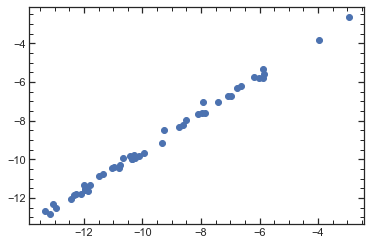

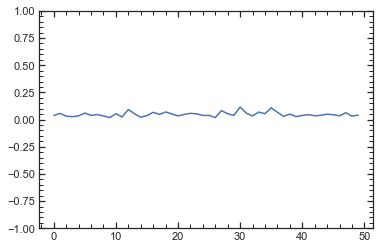

R = 0.9979718262490889
Are data consistent? (R>0.99) yes


In [11]:
database = pd.ExcelFile('Gold_Sentinel_PGRS.xlsx', engine='openpyxl')
sp17 = database.parse('SP17 Half+Right')['<σ0> (VV) (campo "safe_half+right") [dB]'].values
au17 = database.parse('AU17 Half+Right')['<σ0> (VV) (campo "safe_half+right") [dB]'].values
tot17 = np.append(sp17,au17)

sp17_gee = df_tot['VV[dB]'].values[0:25]
au17_gee = df_tot['VV[dB]'].values[-25:]
tot17_gee = np.append(sp17_gee,au17_gee)

plt.scatter(tot17, tot17_gee)
plt.show()
plt.plot((tot17-tot17_gee)/tot17)
plt.ylim(-1,1)
plt.show()

R=np.corrcoef(tot17,tot17_gee,rowvar=False)[0][1]; print('R =', R)
print('Are data consistent? (R>0.99)', 'yes' if R>0.99 else 'no')

### [WIP] Cosine normalization

In [18]:
vv168 = df_tot.loc[df_tot.Orb==168]['VV[dB]']

(array([3., 2., 5., 7., 5., 7., 3., 2., 1., 1.]),
 array([-11.78602873, -10.87025331,  -9.95447789,  -9.03870247,
         -8.12292705,  -7.20715163,  -6.29137621,  -5.3756008 ,
         -4.45982538,  -3.54404996,  -2.62827454]),
 <BarContainer object of 10 artists>)

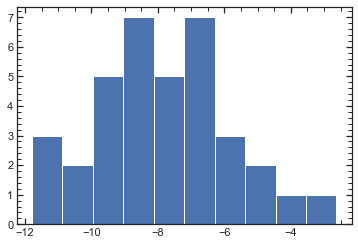

In [22]:
plt.hist(vv168)